In [1]:
%load_ext autotime
import numpy as np
from keras.layers import Input, Dense, Conv1D
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
a=np.genfromtxt('data_for_clustering.csv', delimiter=',')
a=a[:-1]
print(a[1])
x=a[:250*910]
x=x[20*250:]
x=x.reshape(-1,250)
me=np.mean(x,axis=1)
x=(x.T-me).T
x.shape

39963.59


(890, 250)

time: 2.4 s


In [13]:
encoding_dim = 30
 
# this is our input placeholder
input_img = Input(shape=(250,))
# "encoded" is the encoded representation of the input
encoded0=Dense(125,activation='linear')(input_img)
encoded1=Dense(60,activation='linear')(encoded0)
encoded = Dense(encoding_dim, activation='linear')(encoded1)
# "decoded" is the lossy reconstruction of the input
decoded0=Dense(60,activation='linear')(encoded)
decoded1=Dense(125,activation='linear')(decoded0)
decoded = Dense(250, activation='linear')(decoded1)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (10-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer1 = autoencoder.layers[-1]
decoder_layer2 = autoencoder.layers[-2]
encoded_input1 = Input(shape=(125,))
encoded_input2 = Input(shape=(60,))
decoder1 = Model(encoded_input1, decoder_layer1(encoded_input1))
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')#binary_crossentropy

time: 125 ms


In [14]:
autoencoder.fit(x,x,
epochs=50,
batch_size=10)

Epoch 1/50
890/890 [==============================] - 1s 758us/step - loss: 33225.2146
Epoch 2/50
890/890 [==============================] - 0s 359us/step - loss: 12939.9604
Epoch 3/50
890/890 [==============================] - 0s 360us/step - loss: 7929.7073
Epoch 4/50
890/890 [==============================] - 0s 341us/step - loss: 5784.7180
Epoch 5/50
890/890 [==============================] - 0s 346us/step - loss: 5052.2087
Epoch 6/50
890/890 [==============================] - 0s 340us/step - loss: 4313.4552
Epoch 7/50
890/890 [==============================] - 0s 341us/step - loss: 4221.0279
Epoch 8/50
890/890 [==============================] - 0s 347us/step - loss: 3950.6614
Epoch 9/50
890/890 [==============================] - 0s 352us/step - loss: 3949.1420
Epoch 10/50
890/890 [==============================] - 0s 342us/step - loss: 3943.4907
Epoch 11/50
890/890 [==============================] - 0s 344us/step - loss: 3588.2456
Epoch 12/50
890/890 [=============================

time: 16.3 s


In [15]:
encoded_layer=encoder.predict(x)
decoded_output1=decoder.predict(encoded_layer)
decoded_output2=decoder2.predict(decoded_output1)
# create the decoder model
decoded_output2=decoder1.predict(decoded_output2)


time: 241 ms


In [16]:
encoded_layer[0]

array([ 168.8311  , -427.52206 ,   59.662193,  -89.485695,  113.08437 ,
       -832.6742  , -223.00713 ,  660.52264 ,  483.441   , -610.68353 ,
        424.5374  ,   75.51294 ,   59.212616, -606.6872  ,  267.14114 ,
       -793.1852  , -434.21716 ,  392.32767 , -367.6261  ,  322.73193 ,
        -28.47442 , -400.57257 , -243.42421 ,  -77.52975 ,  185.59343 ,
        538.7865  , -332.21616 ,  241.8444  ,  -89.22975 ,  212.46255 ],
      dtype=float32)

time: 2.99 ms


In [17]:
print(x[0].shape)
print(decoded_output2[0].shape)

(250,)
(250,)
time: 5 ms


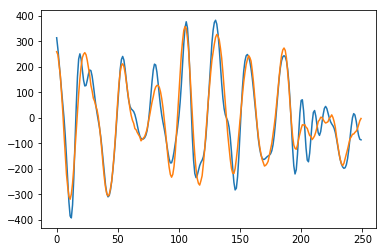

time: 138 ms


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
q=700
plt.plot(range(250),x[q],label=1)
plt.plot(range(250),decoded_output2[q],label=2)

In [19]:
#np.savetxt('compressed_data1.csv',encoded_layer,delimiter=',')

Error in callback <function LineWatcher.stop at 0x000001ABB39A0840> (for post_run_cell):


AssertionError: 

In [20]:
for layer in autoencoder.layers:
    weights = layer.get_weights()

time: 110 ms


In [21]:
weights=np.array(weights)
#weights[1]

Error in callback <function LineWatcher.stop at 0x000001ABB39A0840> (for post_run_cell):


AssertionError: 

In [22]:
config=autoencoder.get_config()
#print(config['layers'])
for layer in config['layers']:
    print(layer)

{'name': 'input_5', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 250), 'dtype': 'float32', 'sparse': False, 'name': 'input_5'}, 'inbound_nodes': []}
{'name': 'dense_7', 'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'units': 125, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_5', 0, 0, {}]]]}
{'name': 'dense_8', 'class_name': 'Dense', 'config': {'name': 'dense_8', 'trainable': True, 'units': 60, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_in